Необходимо предсказать работоспособность насосов. Задача относится к задаче многоклассовой классификации. Данные содержат следующие признаки:

- amount_tsh - Общий статический напор (количество воды, доступное для точки водоснабжения)
- date_recorded - Дата ввода строки
- funder - Кто финансировал скважину
- gps_height - Высота скважины
- installer - Организация, установившая скважину
- longitude - Координаты GPS
- latitude - Координаты GPS
- wpt_name - Название точки водоснабжения, если таковая имеется
- num_private -
- basin - Географический водный бассейн
- subvillage - Географическое положение
- region - Географическое положение
- region_code - Географическое положение (закодировано)
- district_code - Географическое положение (закодировано)
- lga - Географическое положение
- ward - Географическое положение
- population - Население вокруг скважины
- public_meeting - Верно/Неверно
- recorded_by - Группа, вводящая эту строку данных
- scheme_management - Кто управляет водопунктом
- scheme_name - Кто управляет водопунктом
- permit - Если разрешен пункт водоснабжения
- construction_year - Год постройки водопункта
- extraction_type - Тип забора, который использует водозабор
- extraction_type_group - Тип забора, который использует водозабор
- extraction_type_class - Тип забора, который использует водозабор
- management - Как управляется ватерпоинт
- management_group - Как управляется ватерпоинт
- payment - Сколько стоит вода
- payment_type - Сколько стоит вода
- water_quality - Качество воды
- quality_group - Качество воды
- quantity - Количество воды
- quantity_group - Количество воды
- source - Источник воды
- source_type - Источник воды
- source_class - Источник воды
- waterpoint_type - Вид водяного пункта
- waterpoint_type_group - Вид водяного пункта

Для целевого признака существует три возможных значения:

- functional - водопункт функционирует и не требует ремонта
- functional needs repair - водопункт исправен, но нуждается в ремонте
- non functional - водопункт не работает

# 1 Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight

In [2]:
features = pd.read_csv('features.csv', index_col=0)

In [3]:
features

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump


In [4]:
target = pd.read_csv('target.csv', index_col=0)

In [5]:
target

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional
...,...
60739,functional
27263,functional
37057,functional


# 2 EDA

In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55763 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59398 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  war

In [7]:
features.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [8]:
features.isna().sum().sort_values(ascending=False).head(8)

scheme_name          28810
scheme_management     3878
installer             3655
funder                3637
public_meeting        3334
permit                3056
subvillage             371
wpt_name                 2
dtype: int64

В некоторых столбцах есть пропуски. Столбцы с пропусками:

In [9]:
features[features.isna().sum().sort_values(ascending=False).head(8).index]

,scheme_name,scheme_management,installer,funder,public_meeting,permit,subvillage,wpt_name
id,,,,,,,,
69572,Roman,VWC,Roman,Roman,True,False,Mnyusi B,none
8776,NaN,Other,GRUMETI,Grumeti,NaN,True,Nyamara,Zahanati
34310,Nyumba ya mungu pipe scheme,VWC,World vision,Lottery Club,True,True,Majengo,Kwa Mahundi
67743,NaN,VWC,UNICEF,Unicef,True,True,Mahakamani,Zahanati Ya Nanyumbu
19728,NaN,NaN,Artisan,Action In A,True,True,Kyanyamisa,Shuleni
...,...,...,...,...,...,...,...,...
60739,Losaa Kia water supply,Water Board,CES,Germany Republi,True,True,Kiduruni,Area Three Namba 27
27263,Ikondo electrical water sch,VWC,Cefa,Cefa-njombe,True,True,Igumbilo,Kwa Yahona Kuvala
37057,NaN,VWC,NaN,NaN,True,False,Madungulu,Mashine


В категориальных признаках зааменим пропуски на `'Other'`. В двоичных признаках заменим пропуски на моду.

In [10]:
cat_features = ['scheme_name','scheme_management','installer','funder','subvillage','wpt_name']
features[cat_features] = features[cat_features].fillna('Other')

In [11]:
bool_features = ['public_meeting','permit']
features[bool_features].mode()

,public_meeting,permit
0,True,True


In [12]:
features = features.fillna(value={'public_meeting': True, 'permit': True})

C:\Users\Lada\AppData\Local\Temp\ipykernel_4308\2630939012.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = features.fillna(value={'public_meeting': True, 'permit': True})


In [13]:
features.isna().sum().sum()

0

Пропусков больше нет.

In [14]:
target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status_group  59400 non-null  object
dtypes: object(1)
memory usage: 928.1+ KB


In [15]:
target.describe()

,status_group
count,59400
unique,3
top,functional
freq,32259


In [16]:
target.groupby(by='status_group')['status_group'].count()

status_group
functional                 32259
functional needs repair     4317
non functional             22824
Name: status_group, dtype: int64

Есть сильный дисбаланс классов.

# 3 Modelling

Разделим выборку на обучающую и тестовую.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                   target,
                                                  random_state=42,
                                                  test_size=0.2)

## 3.1 H2O

Найдем наилучшую модель с помощью модуля для AutoML H2O.

In [18]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.421-b09, mixed mode)
  Starting server from C:\Users\Lada\VSCodeProjects\OTUS\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Lada\AppData\Local\Temp\tmpbx5hscp_
  JVM stdout: C:\Users\Lada\AppData\Local\Temp\tmpbx5hscp_\h2o_Lada_started_from_python.out
  JVM stderr: C:\Users\Lada\AppData\Local\Temp\tmpbx5hscp_\h2o_Lada_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,H2O_from_python_Lada_u0emuz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.508 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [19]:
train = pd.concat([X_train, y_train], axis=1)

In [20]:
train = h2o.H2OFrame(train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [21]:
y = "status_group"
x = train.columns
x.remove(y)

In [22]:
aml = H2OAutoML(max_runtime_secs=60, seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |
20:48:48.22: AutoML: XGBoost is not available; skipping it.
20:48:48.69: _train param, Dropping bad and constant columns: [recorded_by]

██████████████████████████
20:49:13.65: _train param, Dropping bad and constant columns: [recorded_by]

████████████
20:49:24.86: _train param, Dropping unused columns: [recorded_by]

██████
20:49:29.837: _train param, Dropping bad and constant columns: [recorded_by]

███
20:49:33.489: _train param, Dropping bad and constant columns: [recorded_by]

███
20:49:36.827: _train param, Dropping bad and constant columns: [recorded_by]

████
20:49:40.149: _train param, Dropping bad and constant columns: [recorded_by]

████
20:49:43.525: _train param, Dropping unused columns: [recorded_by]

███
20:49:46.598: _train param, Dropping unused columns: [recorded_by]

██| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_1_AutoML_1_20241012_204847


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    11                 33                          1.4258e+06             20           20           20            1659          3514          2619.09

ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.17590002151330464
RMSE: 0.41940436515766577
LogLoss: 1.8207290723580458
Mean Per-Class Error: 0.35900200285443923
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
functional    functional needs repair    non functional    Error     Rate
------------  -------------------------  ----------------  --------  --------------
15590         510                        1929              0.135282  2 439 / 18 029
1238          746                        428               0.690713  1 666 / 2 412
2922          244                        9447              0.251011  3 166 / 12 613
19750         1500                       11804             0.219973  7 271 / 33 054

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.780027
2    0.939856
3    1

ModelMetricsMultinomial: drf
** Reported on validation data. **

MSE: 0.1573997078684057
RMSE: 0.3967363203292657
LogLoss: 0.7642086423094742
Mean Per-Class Error: 0.35020449535276027
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
functional    functional needs repair    non functional    Error     Rate
------------  -------------------------  ----------------  --------  -----------
2330          41                         231               0.104535  272 / 2 602
171           97                         58                0.702454  229 / 326
424           25                         1394              0.243625  449 / 1 843
2925          163                        1683              0.19912   950 / 4 771

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.80088
2    0.956194
3    1

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_logloss    training_classification_error    training_auc    training_pr_auc    validation_rmse    validation_logloss    validation_classification_error    validation_auc    validation_pr_auc
--  -------------------  ----------  -----------------  ---------------  ------------------  -------------------------------  --------------  -----------------  -----------------  --------------------  ---------------------------------  ----------------  -------------------
    2024-10-12 20:49:29  0.050 sec   0                  nan              nan                 nan                              nan             nan                nan                nan                   nan                                nan               nan
    2024-10-12 20:49:31  1.865 sec   5                  0.451074         3.64312             0.239052                         nan             nan                0.403882           1.18691               0.207713                           nan       

In [23]:
lb = aml.leaderboard
lb.head()

model_id,mean_per_class_error,logloss,rmse,mse
DRF_1_AutoML_1_20241012_204847,0.350204,0.764209,0.396736,0.1574
GBM_1_AutoML_1_20241012_204847,0.353476,0.486639,0.391119,0.152974
StackedEnsemble_BestOfFamily_1_AutoML_1_20241012_204847,0.354496,0.486715,0.395895,0.156733
StackedEnsemble_BestOfFamily_2_AutoML_1_20241012_204847,0.355438,0.48509,0.395483,0.156407
GBM_2_AutoML_1_20241012_204847,0.36154,0.491171,0.397652,0.158127
GBM_4_AutoML_1_20241012_204847,0.367685,0.511455,0.408161,0.166595
GBM_3_AutoML_1_20241012_204847,0.369245,0.497198,0.400512,0.16041
StackedEnsemble_AllModels_1_AutoML_1_20241012_204847,0.449799,0.565283,0.434096,0.188439
GLM_1_AutoML_1_20241012_204847,0.553663,0.797695,0.529351,0.280213


Наилучшей оказалась модель случайного леса. Проверим ее на тестовой выборке.

In [24]:
test = h2o.H2OFrame(X_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [25]:
pred = aml.predict(test)
pred.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\Lada\VSCodeProjects\OTUS\.venv\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset column 'funder' has levels not trained on: ["Abas Ka", "Abdala", "Abddwe", "Act", "Act Mara", "Action In A", "Afric", "Africa Amini Alama", "Afriican Reli", "Aic Kij", ...179 not listed..., "Villagers Mpi", "Villlage Contributi", "Wafidhi Wa Ziwa T", "Wamissionari Wa Kikatoriki", "Wanginyi Water", "Warento", "Wcst", "Wug And Ded", "Yasini", "Zao"]
  warnings.warn(w)
c:\Users\Lada\VSCodeProjects\OTUS\.venv\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset column 'installer' has levels not trained on: ["ABD", "ABDALA", "ACT", "ACT MARA", "AIC KI", "AQUA WEL", "AQUA Wel", "AQUARMAN DRILLERS", "Active KMK", "Adrs", ...202 not listed..., "Zao", "care international", "desk and chair foundation", "germany", "local", "local technical tec", "lusajo", "maji mugumu", "mwita kichere", "nchagwa"]
  warnings.warn(w)
c:\Users\Lada\VSCodeProjects\OTUS\.venv\Lib\site-package

predict,functional,functional needs repair,non functional
non functional,0,0.0833333,0.916667
functional,0.807993,0,0.192007
functional,0.862369,0.0940767,0.043554
non functional,0.336627,0.174543,0.488829
functional,0.979694,0.0153681,0.00493823
non functional,0,0,1
functional,0.768014,0.126027,0.105959
non functional,0,0,1
non functional,0.047619,0,0.952381
functional,0.623517,0.188998,0.187485


В качестве метрики рассчитаем f1-меру с макроусреднением для несбалансированных данных.

In [26]:
f1_h2o = f1_score(y_test, pred['predict'].as_data_frame(), average=None)
f1_h2o

c:\Users\Lada\VSCodeProjects\OTUS\.venv\Lib\site-packages\h2o\frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


array([0.84016602, 0.39215686, 0.79025399])

## 3.2 CatBoost

### 3.2.1 Base

Обучим модель CatBoostClassifier c минимальными настройками гиперпараметров, не учитывая дисбаланс классов.

In [27]:
# параметры для обучения
est_params = {
  'max_depth': 5,
  'n_estimators': 200,
  'learning_rate': 0.01,
  'random_state': 42,
  'verbose': 200,
}

ctb_model = CatBoostClassifier(**est_params)

In [28]:
X_train = X_train.drop(columns=['date_recorded'])
X_test = X_test.drop(columns=['date_recorded'])

In [29]:
X_train = X_train.astype('float', errors='ignore')
X_test = X_test.astype('float', errors='ignore')

In [30]:
X_train[['region_code', 'district_code']] = X_train[['region_code', 'district_code']].astype('int')
X_test[['region_code', 'district_code']] = X_test[['region_code', 'district_code']].astype('int')

In [31]:
cat_col = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name',
       'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']

In [32]:
ctb_model.fit(X_train,
              y_train,
              cat_features=cat_col,
              plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0905811	total: 441ms	remaining: 1m 27s
199:	learn: 0.6241093	total: 56.4s	remaining: 0us


Протестируем модель на тестовых данных.

In [33]:
pred = ctb_model.predict(X_test)

In [34]:
f1_cb_base = f1_score(y_test, pred, average=None)
f1_cb_base

array([0.83001172, 0.0886918 , 0.76773962])

### 3.2.2 Balanced

Обучим модель CatBoostClassifier c учетом дисбаланса классов.

In [35]:
y_train['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [36]:
classes = y_train['status_group'].unique()
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train['status_group'])
class_weights = dict(zip(classes, weights))

In [37]:
# параметры для обучения
est_params = {
  'max_depth': 5,
  'n_estimators': 200,
  'learning_rate': 0.01,
  'random_state': 42,
  'verbose': 200,
  'class_weights': class_weights
}

ctb_model = CatBoostClassifier(**est_params)

In [38]:
ctb_model.fit(X_train,
              y_train,
              cat_features=cat_col,
              plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0933449	total: 284ms	remaining: 56.5s
199:	learn: 0.7614288	total: 56.7s	remaining: 0us


In [39]:
pred = ctb_model.predict(X_test)

In [40]:
f1_cb_balanced = f1_score(y_test, pred, average=None)
f1_cb_balanced

array([0.7640224 , 0.36396075, 0.75930756])

### 3.2.3 С автоматическим отбором признаков

Воспользуемся методом автоматического отбора признаков для удаления незначащих признаков и обучим модель CatBoostClassifier.

In [41]:
features = X_train.drop(columns=cat_col).columns
MI = mutual_info_classif(X_train.drop(columns=cat_col), y_train['status_group'], random_state=42)
MI_df = pd.Series(MI, index=features)

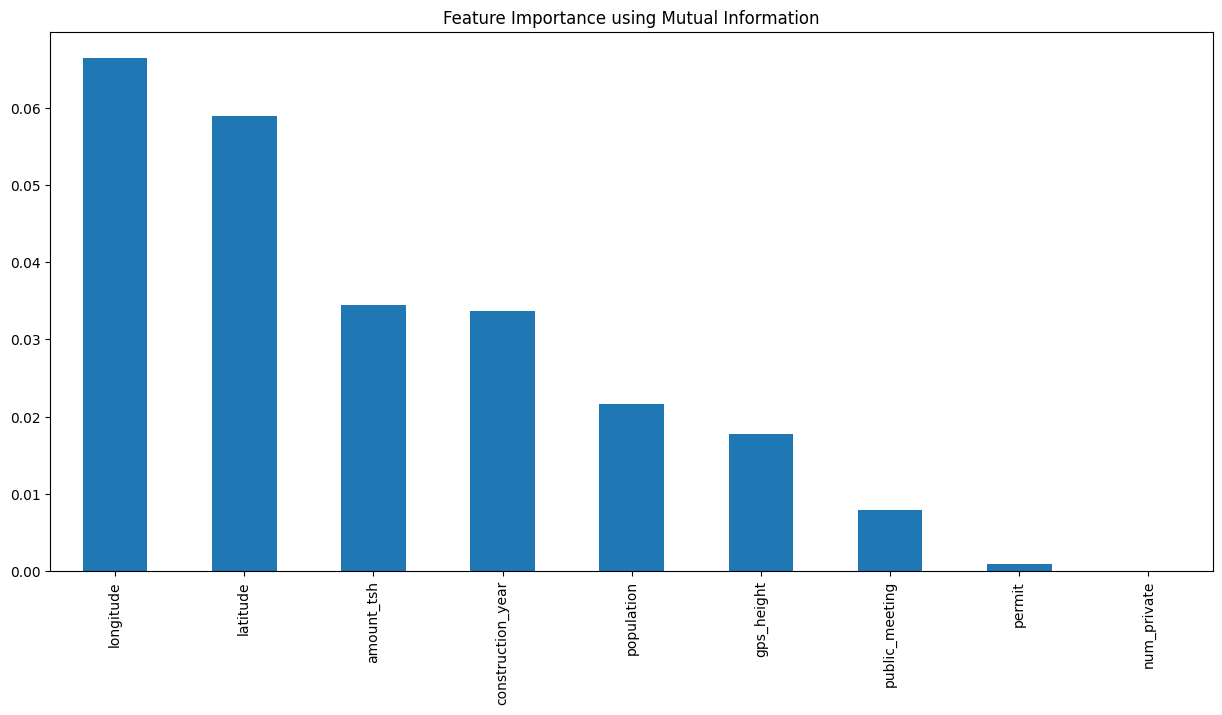

In [42]:
MI_df.sort_values(ascending=False).plot.bar(figsize=(15, 7))
plt.title("Feature Importance using Mutual Information")
plt.show()

Наименьший прирост информации дают столбцы `'permit'` и `'num_private'`. Удалим их из признаков.

In [43]:
# параметры для обучения
est_params = {
  'max_depth': 5,
  'n_estimators': 200,
  'learning_rate': 0.01,
  'random_state': 42,
  'verbose': 200,
  'class_weights': class_weights
}

ctb_model = CatBoostClassifier(**est_params)

In [44]:
ctb_model.fit(X_train.drop(columns=['permit', 'num_private']),
              y_train,
              cat_features=cat_col,
              plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0937000	total: 293ms	remaining: 58.4s
199:	learn: 0.7623612	total: 1m	remaining: 0us


In [45]:
pred = ctb_model.predict(X_test.drop(columns=['permit', 'num_private']))

In [46]:
f1_cb_mi = f1_score(y_test, pred, average=None)
f1_cb_mi

array([0.76193667, 0.36746809, 0.75973027])

# 4 Выводы

Решалась задача многоклассовой классификации. 

Была выполнена предобработка данных - пропуски в категориальных признаках были зааменены на `'Other'`, в двоичных - на моду. Был обнаружен сильный дисбаланс классов.

Для решения задачи были обучены несколько алгоритмов:
1. Поиск наилучшего с помощью H2O.ai
2. CatBoostClassifier без учета дисбаланса классов
3. CatBoostClassifier с учетом дисбаланса классов
4. CatBoostClassifier с предварительным автоматическим отбором признаков методом MI

В результате работы H2O.ai в качестве наилучшей была найдена модель случайного леса Distributed Random Forest. Алгоритм был протестирован на тестовых данных. В качестве метрики была выбрана f1-мера с макроусреднением. Результат работы алгоритма на тестовых данных:

In [51]:
print(f1_h2o)
print(np.mean(f1_h2o))

[0.84016602 0.39215686 0.79025399]
0.6741922933286952


Метрики качества алгоритма CatBoostClassifier на тестовых данных без учета дисбаланса классов:

In [52]:
print(f1_cb_base)
print(np.mean(f1_cb_base))

[0.83001172 0.0886918  0.76773962]
0.5621477129396566


Метрики качества алгоритма CatBoostClassifier на тестовых данных с учетом дисбаланса классов:

In [53]:
print(f1_cb_balanced)
print(np.mean(f1_cb_balanced))

[0.7640224  0.36396075 0.75930756]
0.6290969054525917


Метрики качества алгоритма CatBoostClassifier на тестовых данных с предварительным автоматическим отбором признаков методом MI с учетом дисбаланса классов:

In [54]:
print(f1_cb_mi)
print(np.mean(f1_cb_mi))

[0.76193667 0.36746809 0.75973027]
0.6297116791690209


Наилучшее качество получено алгоритмом, полученным с помощью AutoML-фреймворка H2O. Также небольшой прирост качества получен для модели CatBoostClassifier при предварительном автоматическом отборе признаков методом MI.